In [2]:
import pandas as pd
import numpy as np
import datetime
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm
import torch.nn.functional as F
from FirthLogit import Firth_Logit
from imblearn.over_sampling import SMOTE
import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random
from keras import regularizers
from keras import models,layers,optimizers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from AE import *
from keras.callbacks.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(rc = {'figure.figsize':(8,5)})
from sklearn.preprocessing import OneHotEncoder


Using TensorFlow backend.


# Preprocessing & Feature Engineering

In [3]:
df = pd.read_csv('creditcard.csv')
y = df.Class

0.172% of transactions in the dataset are fraudulent

### Transaction Amount

<AxesSubplot:>

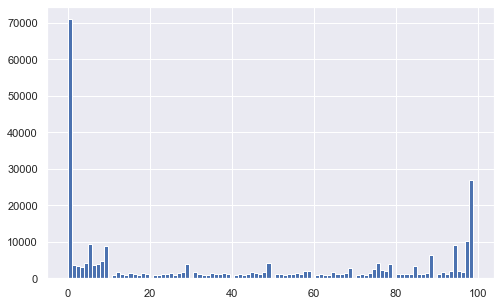

In [4]:
df['Zero_Amount'] = (df.Amount == 0).astype(int)
df['Outlier_Amount'] = (df.Amount > df.Amount.mean()+df.Amount.std()*2).astype(int)
df['Cents'] = df.Amount.apply(lambda x: int(str(x).split('.')[1]))
df.Cents.hist(bins=100)

<AxesSubplot:xlabel='Amount', ylabel='Density'>

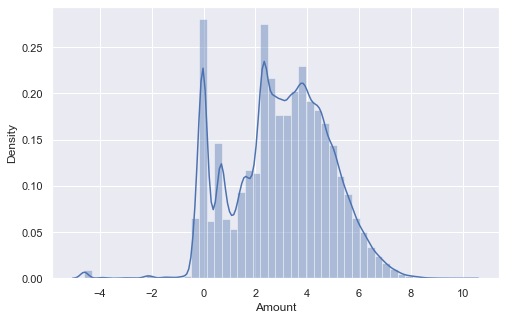

In [5]:
df.Amount[df.Amount!=0] = np.log(df.Amount[df.Amount!=0])
sns.distplot(df.Amount)

### Transaction Time

<AxesSubplot:>

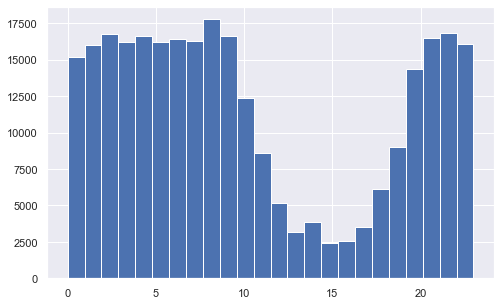

In [6]:
time_df = pd.DataFrame(df.Time)
base_date = datetime.datetime.now()
time_df['Date'] = base_date + time_df.Time.apply(lambda x: datetime.timedelta(seconds=x))
time_df['Hour'] = time_df.Date.apply(lambda x: x.hour)
time_df['Minute'] = time_df.Date.apply(lambda x: x.minute)
time_df['Day'] = (time_df.Time/(60*60*24))//1
time_df.drop(['Time','Date'],axis=1,inplace=True)
time_df.Hour.hist(bins=24)

In [7]:
ohe = OneHotEncoder(sparse=False)
time_df = ohe.fit_transform(time_df.astype(str))
cats = ohe.categories_
labels = ['Hour_' + h for h in cats[0]]
labels += ['Min_' + m for m in cats[1]]
labels += ['Day_' + d for d in cats[2]]
time_df = pd.DataFrame(time_df,columns=labels)

In [8]:
X = df.drop(['Class','Time'],axis=1)
y = df.Class

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)
time_train, time_val = train_test_split(time_df,test_size=0.2,random_state=0)

# Class-Weighted MLP

### Preprocess data

In [56]:
X_train = X_train.join(time_df)
X_val = X_val.join(time_df)
y_train_keras = to_categorical(y_train)
y_val_keras = to_categorical(y_val)
class_weights = {0:1,1:1/y_train.mean()}
sc = StandardScaler()
X_train_keras = sc.fit_transform(X_train)
X_val_keras = sc.fit_transform(X_val)

### Set checkpoint and learning rate scheduler

In [58]:
scheduler = ReduceLROnPlateau(monitor='loss',
                                factor=0.8, 
                                patience=10, 
                                verbose=1,
                                mode='auto', 
                                min_delta=0.0001, 
                                cooldown=0, 
                                min_lr=0)
checkpoint = ModelCheckpoint('checkpoint.best.hdf5',  verbose=1, save_best_only=True, mode='auto')

### Instantiate and compile MLP

In [61]:
nn = models.Sequential()
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(32,activation='relu'))
nn.add(layers.Dense(16,activation='relu'))
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(8,activation='relu'))
nn.add(layers.Dense(4,activation='relu'))
nn.add(layers.Dense(2,activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer='adam')

### Train MLP

In [ ]:
nn.fit(X_train_keras, 
       y_train_keras, 
       epochs=100, 
       class_weight=class_weights,
       batch_size=512,
       validation_data=(X_val_keras,y_val_keras),
       callbacks=[scheduler,checkpoint])

## Get predictions from checkpoint

In [69]:
results_nn = models.Sequential()
results_nn.add(layers.Dense(64,input_shape=(X_train.shape[1],),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
results_nn.add(layers.Dense(32,activation='relu'))
results_nn.add(layers.Dense(16,activation='relu'))
results_nn.add(layers.Dense(8,activation='relu'))
results_nn.add(layers.Dense(4,activation='relu'))
results_nn.add(layers.Dense(2,activation='sigmoid'))
results_nn.load_weights('checkpoint.best.hdf5')
results_nn.compile(loss='binary_crossentropy',optimizer='adam')

val_preds = results_nn.predict(X_val_keras)
train_preds = results_nn.predict(X_train_keras)

train_results = pd.DataFrame()
val_results = pd.DataFrame()

train_results['mlp'] = train_preds[:,1]
val_results['mlp'] = val_preds[:,1]

# Random Forest with Grid Search on SMOTE data

In [82]:
rf = RandomForestClassifier()
param_grid = {'max_depth': [3,5,10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200,500]}

smote = SMOTE(n_jobs=-1)
smote_train_X, smote_train_y = smote.fit_resample(X_train,y_train)

search = GridSearchCV(rf, param_grid, cv=3,verbose=1)
search.fit(smote_train_X,smote_train_y)

train_results['smote'] = search.predict_proba(X_train)[:,1]
val_results['smote'] = search.predict_proba(X_val)[:,1]

Fitting 3 folds for each of 81 candidates, totalling 243 fits


# Obtain bagged logistic regression with penalized MLE results

In [114]:
def get_bagged_PMLE_results(X_train,y_train,functions,function_labels,n_iters=20):
    train = pd.DataFrame(np.zeros((X_train.shape[0],len(functions))),columns=function_lables)
    val = pd.DataFrame(np.zeros((X_val.shape[0],len(functions))),columns=function_lables)
    for i in range(n_iters):
        print('Epoch', i+1)
        X = X_train[y_train==1].sample(frac=0.05).append(X_train[y_train==0].sample(frac=0.05))
        y = y_train.loc[X.index]
        for j in range(len(functions)):
            function = functions[j]
            label = function_labels[j]
            print(label)
            function.fit(X,y)
            train[label] = (i*train[label] + function.predict_proba(X_train))/(i+1)
            val[label] =  (i*val[label] + function.predict_proba(X_val))/(i+1)
    return train, val

firth = Firth_Logit(num_iters=125,lr=0.05, metric='log_loss', readout_rate=40)
FLIC = Firth_Logit(num_iters=125,lr=0.05,FLIC=True, metric='log_loss', readout_rate=40)
t_firth = Firth_Logit(num_iters=125,lr=0.05,lmbda=0.01, metric='log_loss', readout_rate=40)

functions = [firth,FLIC,t_firth]
function_labels = ['firth','FLIC','t_firth']

firth_train, firth_val = get_bagged_PMLE_results(X_train,y_train,functions,function_labels,n_iters=20)
train_results = train_results.join(firth_train)
val_results = val_results.join(firth_val)

Epoch 1
firth
Batch 0 Score: 13.175400069942299
Batch 40 Score: 13.076056914306553
Batch 80 Score: 13.06817541044508
Batch 120 Score: 13.06562649085181
FLIC
Batch 0 Score: 13.175400069942299
Batch 40 Score: 13.076056914306553
Batch 80 Score: 13.06817541044508
Batch 120 Score: 13.06562649085181
t_firth
Batch 0 Score: 13.17865510465135
Batch 40 Score: 13.0685009458598
Batch 80 Score: 13.069876476445524
Batch 120 Score: 13.069835079395391
Epoch 2
firth
Batch 0 Score: 13.238213025530445
Batch 40 Score: 13.224878704289766
Batch 80 Score: 13.227043302434243
Batch 120 Score: 13.227110136676174
FLIC
Batch 0 Score: 13.238213025530445
Batch 40 Score: 13.224878704289766
Batch 80 Score: 13.227043302434243
Batch 120 Score: 13.227110136676174
t_firth
Batch 0 Score: 13.242696352429887
Batch 40 Score: 13.238274238292577
Batch 80 Score: 13.235513572424887
Batch 120 Score: 13.232887093616407
Epoch 3
firth
Batch 0 Score: 13.26521963994091
Batch 40 Score: 13.265211296950252
Batch 80 Score: 13.265202958988

KeyboardInterrupt: 

# Autoencoder Anomaly Detection
### With undercomplete, regularized and denoising autoencoders using pytorch

## Data Processing

In [12]:
X_train = X_train.join(time_train)
X_val = X_val.join(time_val)

# identify non-fraud rows
normal_inds = y_train[y_train==0].reset_index().index

#Standardize dfs
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.fit_transform(X_val)

n_features = X_train_sc.shape[1]

#Convert non-fraud rows to pytorch tensor
normal_train = X_train_sc[normal_inds,:]
normal_torch = torch.from_numpy(normal_train,).type(torch.FloatTensor)

#Convert train and val sets to pytorch tensor
train_torch = torch.from_numpy(X_train_sc).type(torch.FloatTensor)
val_torch = torch.from_numpy(X_val_sc).type(torch.FloatTensor)

## Train Autoencoders

### Autoencoder I: Undercomplete with Dropout

#### Instantiate encoder and loss function

In [13]:
ae1 = AutoEncoder(n_features,int(n_features*1.5//1),dropout=0.3)
loss_func = nn.MSELoss()

#### Train autoencoder

In [ ]:
#Start with high learning rate
optimizer = torch.optim.SGD(ae1.parameters(), lr=0.02, momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=4, verbose=True)
train_autoencoder(model=ae1,
                   dataset=normal_torch,
                   loss_func=loss_func,
                   optimizer=optimizer,
                   batch_size=256,
                   epochs=100,
                   lr_rate_scheduler=scheduler,
                   validation_tensor=val_torch,
                   y_val = y_val)


Epoch 1

Batch 0 Loss: 1.0539
Batch 222 Loss: 0.9158
Batch 444 Loss: 0.8300
Batch 666 Loss: 0.7085
Batch 888 Loss: 0.9731

EPOCH 1 LOSS: 0.6390

Reconstruction error recall: 0.0099

Epoch 2

Batch 0 Loss: 0.6533
Batch 222 Loss: 0.5481
Batch 444 Loss: 0.5311
Batch 666 Loss: 0.4937
Batch 888 Loss: 0.4783

EPOCH 2 LOSS: 0.4641

Reconstruction error recall 0.0099
Change: 0.0000%

Epoch 3

Batch 0 Loss: 0.4340
Batch 222 Loss: 0.5265
Batch 444 Loss: 0.4071
Batch 666 Loss: 0.4101
Batch 888 Loss: 0.3834

EPOCH 3 LOSS: 0.4000

Reconstruction error recall 0.0198
Change: 1.0000%

Epoch 4

Batch 0 Loss: 0.3759
Batch 222 Loss: 0.4022
Batch 444 Loss: 0.3618
Batch 666 Loss: 0.4566
Batch 888 Loss: 0.3529

EPOCH 4 LOSS: 0.3638

Reconstruction error recall 0.0297
Change: 0.5000%

Epoch 5

Batch 0 Loss: 0.3550
Batch 222 Loss: 0.3463
Batch 444 Loss: 0.3776
Batch 666 Loss: 0.3959
Batch 888 Loss: 0.3388

EPOCH 5 LOSS: 0.3413

Reconstruction error recall 0.0000
Change: -1.0000%

Epoch 6

Batch 0 Loss: 0.334


Reconstruction error recall 0.0396
Change: -0.4286%

Epoch 41

Batch 0 Loss: 0.2092
Batch 222 Loss: 0.2053
Batch 444 Loss: 0.2045
Batch 666 Loss: 0.1999
Batch 888 Loss: 0.2348

EPOCH 41 LOSS: 0.2102

Reconstruction error recall 0.0198
Change: -0.5000%

Epoch 42

Batch 0 Loss: 0.2000
Batch 222 Loss: 0.2204
Batch 444 Loss: 0.2029
Batch 666 Loss: 0.2040
Batch 888 Loss: 0.2028

EPOCH 42 LOSS: 0.2085

Reconstruction error recall 0.0594
Change: 2.0000%

Epoch 43

Batch 0 Loss: 0.2103
Batch 222 Loss: 0.2170
Batch 444 Loss: 0.2116


#### Save results

In [39]:
output1 = ae1(normal_torch)
train_output1 = ae1(train_torch)
val_output1 = ae1(val_torch)

### Autoencoder II: L2 Regularization

In [32]:
ae2 = AutoEncoder(n_features,n_features)
loss_func = nn.MSELoss()

In [ ]:
optimizer = torch.optim.RMSprop(ae2.parameters(), lr=0.2, weight_decay=0.25)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae2,
                   dataset=output1,
                   loss_func=loss_func,
                   optimizer=optimizer,
                   batch_size=256,
                   epochs=500,
                   validation_tensor=val_torch,
                   lr_rate_scheduler=scheduler,
                   y_val=y_val)

In [43]:
output2 = ae2(output1)
train_output2 = ae2(train_output1)
val_output2 = ae2(val_output1)

### Autoencoder III: Denoising

In [46]:
ae3 = AutoEncoder(n_features,n_features)
loss_func = nn.MSELoss()

In [ ]:
optimizer = torch.optim.SGD(ae3.parameters(), lr=0.2,momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae3,
                  dataset=output2,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=512,
                  epochs=10,
                  noise_factor=0.9,
                  validation_tensor=val_torch,
                  y_val=y_val)

In [48]:
output3 = ae3(output2)
train_output3 = ae3(train_output2)
val_output3 = ae3(val_output2)

### Autoencoder IV: L1 Regularization

In [49]:
ae4 = AutoEncoder(n_features,n_features)

def L1_loss(recon,inputs):
    MSELoss = nn.MSELoss()
    loss = MSELoss(recon,inputs)
    for param in ae4.parameters():
        loss += lmbda*torch.sum(torch.abs(param))
    return loss

loss_func = L1_loss

In [ ]:
lmbda=0.25
optimizer = torch.optim.SGD(ae4.parameters(), lr=0.02,momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae4,
                  dataset=output3,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=512,
                  epochs=200,
                  validation_tensor=val_torch,
                  y_val=y_val)

In [53]:
output4 = ae4(output3)
train_output4 = ae4(train_output3)
val_output4 = ae4(val_output3)

### Autoencoder V: Kitchen Sink

In [61]:
ae5 = AutoEncoder(n_features,int(n_features//4),dropout=0.5)
loss_func = L1_loss

In [ ]:
optimizer = torch.optim.RMSprop(ae5.parameters(), lr=0.02, weight_decay=0.5)
train_autoencoder(model=ae5,
                  dataset=output4,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=1024,
                  epochs=200,
                  noise_factor=0.5,
                  validation_tensor=val_torch,
                  y_val=y_val)

In [63]:
output5 = ae5(output4)
train_output5 = ae5(train_output4)
val_output5 = ae5(val_output4)

### Add reconstruction score to DFs

In [69]:
final_train_output = train_output5.detach().numpy()
final_val_output = val_output5.detach().numpy()

#calculate reconstruction score
train_reconstruction_score = np.power(X_train_sc - final_train_output,2).sum(axis=1)
train_reconstruction score = train_reconstruction_score/(train_reconstruction_score.max()-train_reconstruction_score.min())

#normalize
val_reconstruction_score = np.power(X_val_sc - final_val_output,2).sum(axis=1)
val_reconstruction score = val_reconstruction_score/(val_reconstruction_score.max()-val_reconstruction_score.min())

train_results['recon_score'] = train_reconstruction_score
val_results['recon_score'] = val_reconstruction_score

# Run all results through FLIC to obtain final results

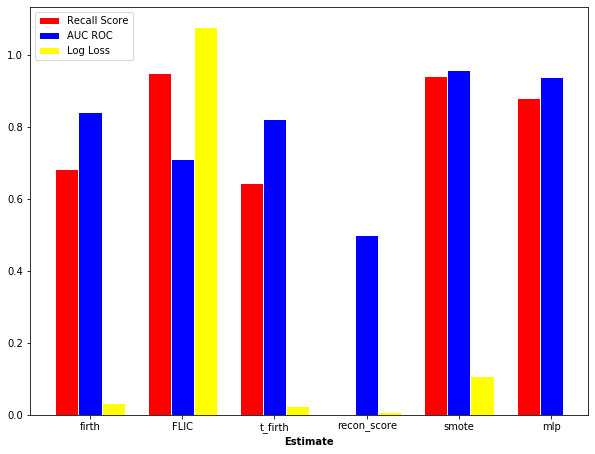

In [47]:
recalls = []
auc_rocs = []
log_losses =[]
for col in val_results.columns:
    recalls.append(recall_score(y_val,val_results[col].round()))
    auc_rocs.append(roc_auc_score(y_val,val_results[col].round()))
    log_losses.append(log_loss(y_val,val_results[col]))
    
estimators = list(val_results.columns)
width = 0.25

plt.figure(figsize=(10,7.5))
r1 = np.arange(len(recalls))
r2 = [i + width for i in r1]
r3 = [i + width for i in r2]

plt.bar(r1, recalls, color='red', width=width, edgecolor='white', label='Recall Score')
plt.bar(r2, auc_rocs, color='blue', width=width, edgecolor='white', label='AUC ROC')
plt.bar(r3, log_losses, color='yellow', width=width, edgecolor='white', label='Log Loss')

plt.xlabel('Estimate', fontweight='bold')
plt.xticks([i + width for i in range(len(recalls))], estimators)
plt.legend()


In [ ]:
FLIC = Firth_Logit(num_iters=100,lr=0.05,FLIC=True, metric='recall_score', readout_rate=10)
train = np.zeros(X_train.shape[0])
val = np.zeros(X_val.shape[0])
for i in range(20):
    print('Epoch:',i+1)
    X = train_results[y_train==1].sample(frac=0.05).append(train_results[y_train==0].sample(frac=0.05))
    y = y_train.loc[X.index]
    FLIC.fit(X,y)
    train = ((i)*train + FLIC.predict_proba(train_results))/(i+1)
    val =  ((i)*val + FLIC.predict_proba(val_results))/(i+1)

# Final validation set area under the ROC curve score

In [41]:
roc_auc_score(y_val,val)

0.9884146871274243